In [1]:
#Probabilistic ScoreCard

In [2]:
import os
import weatherbench2
import xarray as xr
import math
from weatherbench2.regions import SliceRegion, ExtraTropicalRegion
from weatherbench2.evaluation import evaluate_in_memory
from weatherbench2 import config
import numpy as np
import sigkernel
import torch
from einops import rearrange
from itertools import product
import cython
import matplotlib.pyplot  as plt
import tqdm
#import Functions as fu
import line_profiler
from datetime import datetime, timedelta
from multiprocessing import Pool, cpu_count
import time
from weatherbench2.metrics import MSE, ACC
from weatherbench2.regions import SliceRegion
import seaborn as sns
from dateutil.relativedelta import relativedelta




In [3]:
import apache_beam

In [ ]:
overallIFSENSE = xr.open_dataset('WeatherData/NEWENSERAmonths11.nc')
for i in range(11):
    results = xr.open_dataset('WeatherData/NEWENSERAmonths' + str(i) + '.nc')
    overallIFSENSE = overallIFSENSE + results

overallIFSENSE = overallIFSENSE/12

In [5]:
overallIFSENSE = overallIFSENSE.isel(lead_time=slice(0, None,2)).isel(lead_time=slice(1, None))
overallIFSENSE   #This selection reduces 6h time to 12 hour to compare with gcm

<xarray.Dataset>
Dimensions:              (lead_time: 30, region: 3, metric: 3, level: 2)
Coordinates:
  * lead_time            (lead_time) timedelta64[ns] 0 days 12:00:00 ... 15 d...
  * region               (region) object 'northernhemisphere' ... 'southernhe...
  * metric               (metric) object 'CRPS' 'EnergyScore' 'EnsMSE'
  * level                (level) int32 500 850
Data variables:
    geopotential         (metric, region, lead_time, level) float64 17.79 ......
    temperature          (metric, region, lead_time, level) float64 0.1402 .....
    u_component_of_wind  (metric, region, lead_time, level) float64 0.3842 .....
    v_component_of_wind  (metric, region, lead_time, level) float64 0.4085 .....

In [6]:
overallGCM = xr.open_dataset('WeatherData/NEWENSERAmonthsgcm11.nc')
for i in range(11):
    results = xr.open_dataset('WeatherData/NEWENSERAmonthsgcm' + str(i) + '.nc')
    overallGCM = overallGCM + results

overallGCM = overallGCM/12

In [7]:
overallGCM = overallGCM.isel(lead_time=slice(1,-1))
overallGCM #This selection cuts number of leadtimes to align with IFS

<xarray.Dataset>
Dimensions:              (lead_time: 30, region: 3, metric: 3, level: 2)
Coordinates:
  * lead_time            (lead_time) timedelta64[ns] 0 days 12:00:00 ... 15 d...
  * region               (region) object 'northernhemisphere' ... 'southernhe...
  * metric               (metric) object 'CRPS' 'EnergyScore' 'EnsMSE'
  * level                (level) int32 500 850
Data variables:
    geopotential         (metric, region, lead_time, level) float64 15.47 ......
    temperature          (metric, region, lead_time, level) float64 0.121 ......
    u_component_of_wind  (metric, region, lead_time, level) float64 0.3593 .....
    v_component_of_wind  (metric, region, lead_time, level) float64 0.3948 .....

In [8]:
percentage_diff = (overallGCM - overallIFSENSE) / overallIFSENSE * 100

print(percentage_diff)

<xarray.Dataset>
Dimensions:              (lead_time: 30, region: 3, metric: 3, level: 2)
Coordinates:
  * lead_time            (lead_time) timedelta64[ns] 0 days 12:00:00 ... 15 d...
  * region               (region) object 'northernhemisphere' ... 'southernhe...
  * metric               (metric) object 'CRPS' 'EnergyScore' 'EnsMSE'
  * level                (level) int32 500 850
Data variables:
    geopotential         (metric, region, lead_time, level) float64 -12.99 .....
    temperature          (metric, region, lead_time, level) float64 -13.68 .....
    u_component_of_wind  (metric, region, lead_time, level) float64 -6.481 .....
    v_component_of_wind  (metric, region, lead_time, level) float64 -3.36 ......


In [9]:
percentage_diff = percentage_diff.where(percentage_diff.metric != "EnergyScore", drop=True) #Too similar to CRPS so wasn't included
print(percentage_diff)
geopotential = percentage_diff['geopotential'].values
geopotential.shape #now have normal array(metric =2, region =3, leadtime = 60, level =2)

temperature = percentage_diff['temperature'].values
u_component_of_wind = percentage_diff['u_component_of_wind'].values
v_component_of_wind = percentage_diff['v_component_of_wind'].values

<xarray.Dataset>
Dimensions:              (metric: 2, region: 3, lead_time: 30, level: 2)
Coordinates:
  * lead_time            (lead_time) timedelta64[ns] 0 days 12:00:00 ... 15 d...
  * region               (region) object 'northernhemisphere' ... 'southernhe...
  * metric               (metric) object 'CRPS' 'EnsMSE'
  * level                (level) int32 500 850
Data variables:
    geopotential         (metric, region, lead_time, level) float64 -12.99 .....
    temperature          (metric, region, lead_time, level) float64 -13.68 .....
    u_component_of_wind  (metric, region, lead_time, level) float64 -6.481 .....
    v_component_of_wind  (metric, region, lead_time, level) float64 -3.36 ......


In [10]:
u_component_of_wind = u_component_of_wind[:,:,:,0]
v_component_of_wind = v_component_of_wind[:,:,:,0]

In [11]:
weights = np.array([0.07704437, 0.23039114, 0.38151911, 0.52897285, 0.67133229,
       0.80722643, 0.93534654, 1.05445875, 1.16341595, 1.26116882,
       1.34677594, 1.41941287, 1.47838008, 1.52310968, 1.55317091,
       1.56827425, 1.56827425, 1.55317091, 1.52310968, 1.47838008,
       1.41941287, 1.34677594, 1.26116882, 1.16341595, 1.05445875,
       0.93534654, 0.80722643, 0.67133229, 0.52897285, 0.38151911,
       0.23039114, 0.07704437])

southernweights = weights[0:12]
tropicweights = weights[12:20]
northernweights = weights[20:32]

In [12]:
def latsplit(input):
    input = input[:,:,1:]
    inputsouthern = np.sum(input[0:12,:,:] * southernweights[:, None, None], axis=0)
    inputst = np.mean(inputsouthern, axis=0)
    inputsoutherndistance = inputst

    inputtropic = np.sum(input[12:20,:,:] * tropicweights[:, None, None], axis=0)
    inputtt = np.mean(inputtropic, axis=0)
    inputtropicdistance = inputtt

    inputnorthern = np.sum(input[20:32,:,:] * northernweights[:, None, None], axis=0)
    inputnt = np.mean(inputnorthern, axis=0)
    inputnortherndistance = inputnt

    return (inputsoutherndistance,inputtropicdistance,inputnortherndistance)



In [13]:
geo500 = np.load('Signature/geo500.npy')
geo850 = np.load('Signature/geo850.npy')
temp500 = np.load('Signature/temp500.npy')
temp850 = np.load('Signature/temp850.npy')
u500 = np.load('Signature/u500.npy')
v500 = np.load('Signature/v500.npy')


geo500gcm = np.load('Signature/geo500gcm.npy')
geo850gcm = np.load('Signature/geo850gcm.npy')
temp500gcm = np.load('Signature/temp500gcm.npy')
temp850gcm = np.load('Signature/temp850gcm.npy')
u500gcm = np.load('Signature/u500gcm.npy')
v500gcm = np.load('Signature/v500gcm.npy')

In [14]:

ens = [geo500,geo850,temp500,temp850,u500,v500]
gcm = [geo500gcm,geo850gcm,temp500gcm,temp850gcm,u500gcm,v500gcm]

storageval = np.zeros((6,30,3))
storagevalgcm = np.zeros((6,30,3))

for i in range(6):
    south, tropics, northern = latsplit(ens[i])
    storageval[i,:,0] = northern
    storageval[i,:,1] = tropics
    storageval[i,:,2] = south
    south1, tropics1, northern1 = latsplit(gcm[i])
    storagevalgcm[i,:,0] = northern1
    storagevalgcm[i,:,1] = tropics1
    storagevalgcm[i,:,2] = south1

    



In [15]:
percentage_diffsigkernel = -1*(storagevalgcm - storageval) / storageval * 100
percentage_diffsigkernel.shape

(6, 30, 3)

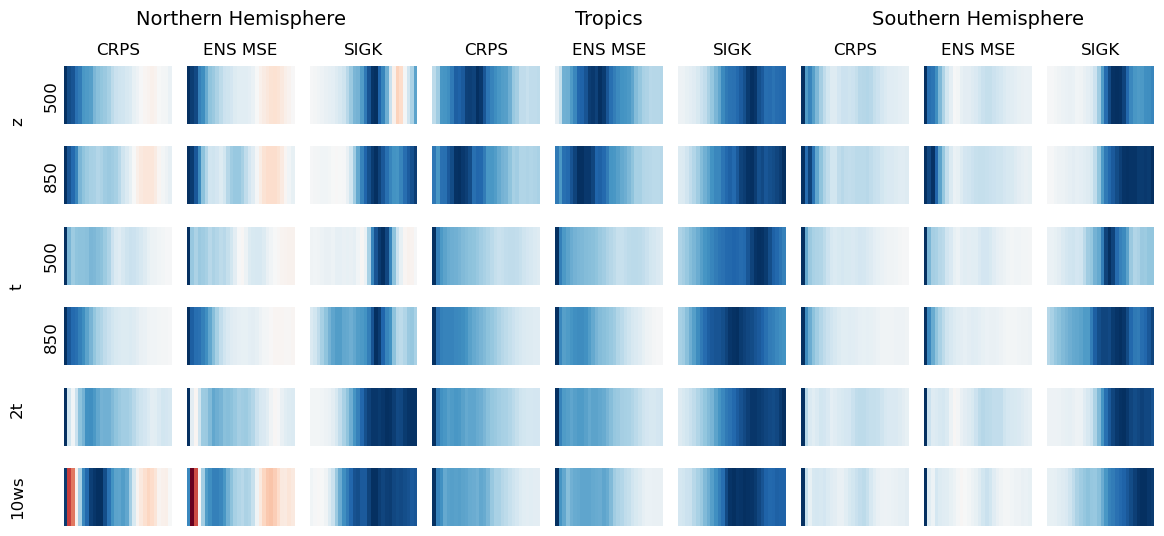

In [16]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import seaborn as sns

# 'CRPS': CRPS(), 
#             'CRPSSpread': CRPSSpread(),
#             'CRPSSkill': CRPSSkill(),
#             'EnergyScore': EnergyScore()

regions = ['Northern Hemisphere', 'Tropics', 'Southern Hemisphere']
metrics = ['CRPS', 'ENS MSE', 'SIGK']
levels = [500, 850]

fig = plt.figure(figsize=(12, 6)) 
spec = gridspec.GridSpec(
    nrows=2 + len(levels) * 2 + 2,  # 2 header rows + 2 levels for geopotential + 2 levels for temperature + 2 rows for 2m_temperature and 10m_wind speed
    ncols=len(regions) * len(metrics), 
    figure=fig, 
    height_ratios=[-0.1, -0.1] + [1] * (len(levels) * 2) + [1, 1]  # Adjust header height ratios and add more rows
)

for region_idx, region in enumerate(regions):
    region_start_col = region_idx * len(metrics)
    region_end_col = region_start_col + len(metrics)

    ax_region = fig.add_subplot(spec[0, region_start_col:region_end_col])
    ax_region.set_title(region, fontsize=14) 
    ax_region.axis('off') 

for region_idx in range(len(regions)):
    for metric_idx, metric in enumerate(metrics):
        col_idx = region_idx * len(metrics) + metric_idx

        ax_metric = fig.add_subplot(spec[1, col_idx])
        ax_metric.text(0.5, 1, metric, ha='center', va='center', fontsize=12, transform=ax_metric.transAxes)
        ax_metric.axis('off')

fig.text(0.04, 0.75, 'z', ha='center', va='center', fontsize=12, rotation='vertical')
for level_idx, level in enumerate(levels):
    for region_idx in range(len(regions)):
        for metric_idx in range(len(metrics)):
            col_idx = region_idx * len(metrics) + metric_idx
            ax = fig.add_subplot(spec[level_idx + 2, col_idx])
            
            if metric_idx<2:
                geopotential_plot_data = geopotential[metric_idx, region_idx, :, level_idx]
            else:
                if level_idx == 0:
                    geopotential_plot_data = percentage_diffsigkernel[0,:,region_idx]
                else:
                    geopotential_plot_data = percentage_diffsigkernel[1,:,region_idx]

            data_for_plot = geopotential_plot_data[np.newaxis, :]
            sns.heatmap(
                data_for_plot,
                cmap='RdBu_r',
                center=0,
                linewidths=0,
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                ax=ax
            )
                
    ax_label = fig.add_subplot(spec[level_idx + 2, 0])
    ax_label.annotate(f'{level}', xy=(-0.05, 0.5), xycoords='axes fraction',
                      ha='right', va='center', fontsize=12, rotation='vertical', annotation_clip=False)
    ax_label.axis('off') 

fig.text(0.04, 0.475, 't', ha='center', va='center', fontsize=12, rotation='vertical')
for level_idx, level in enumerate(levels):
    for region_idx in range(len(regions)):
        for metric_idx in range(len(metrics)):
            col_idx = region_idx * len(metrics) + metric_idx
            ax = fig.add_subplot(spec[level_idx + 2 + len(levels), col_idx])
            
            if metric_idx<2:
                temperature_plot_data = temperature[metric_idx, region_idx, :, level_idx]
            else:
                if level_idx == 0:
                    temperature_plot_data = percentage_diffsigkernel[2,:,region_idx]
                else:
                    temperature_plot_data = percentage_diffsigkernel[3,:,region_idx]


            data_for_plot = temperature_plot_data[np.newaxis, :]
            sns.heatmap(
                data_for_plot,
                cmap='RdBu_r',
                center=0,
                linewidths=0,
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                ax=ax
            )

    ax_label = fig.add_subplot(spec[level_idx + 2 + len(levels), 0])
    ax_label.annotate(f'{level}', xy=(-0.05, 0.5), xycoords='axes fraction',
                      ha='right', va='center', fontsize=12, rotation='vertical', annotation_clip=False)
    ax_label.axis('off') 

fig.text(0.04, 0.27, '2t', ha='center', va='center', fontsize=12, rotation='vertical')
for region_idx in range(len(regions)):
    for metric_idx in range(len(metrics)):
        col_idx = region_idx * len(metrics) + metric_idx
        ax = fig.add_subplot(spec[len(levels) * 2 + 2, col_idx])
        
        if metric_idx<2:
            temperature_2m_plot_data = u_component_of_wind[metric_idx, region_idx, :]
        else:
            temperature_2m_plot_data = percentage_diffsigkernel[4,:,region_idx]

        data_for_plot = temperature_2m_plot_data[np.newaxis, :]
        sns.heatmap(
            data_for_plot,
            cmap='RdBu_r',
            center=0,
            linewidths=0,
            cbar=False,
            xticklabels=False,
            yticklabels=False,
            ax=ax
        )

fig.text(0.04, 0.125, '10ws', ha='center', va='center', fontsize=12, rotation='vertical')
for region_idx in range(len(regions)):
    for metric_idx in range(len(metrics)):
        col_idx = region_idx * len(metrics) + metric_idx
        ax = fig.add_subplot(spec[len(levels) * 2 + 3, col_idx])

        if metric_idx<2:
            wind_speed_10m_plot_data = v_component_of_wind[metric_idx, region_idx, :]
        else:
            wind_speed_10m_plot_data = percentage_diffsigkernel[5,:,region_idx]

        data_for_plot = wind_speed_10m_plot_data[np.newaxis, :]
        sns.heatmap(
            data_for_plot,
            cmap='RdBu_r',
            center=0,
            linewidths=0,
            cbar=False,
            xticklabels=False,
            yticklabels=False,
            ax=ax
        )


plt.tight_layout(rect=[0.05, 0.05, 1, 0.95]) 
plt.show()